In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import entropy

In [17]:
# Define the given functions
# PR(\theta)
def f(y):
    #return x**4 * (1 + x**2)
    return -y**2*(y - 1)**2 - (1-y**2)*(y)**2

# PR(\phi)
def g(x):
    #return y**2 * (1 + y)
    return -x*(np.sqrt(x)-1)**2 - (1-x)*x

# Function to calculate the KL divergence between two Gaussians
# def kl_divergence(x_target, y):
#     if y < 0:
#         y = 0
#     mu1, sigma1 = np.sqrt(y), 1
#     mu2, sigma2 = x_target, 1
#     return np.log(sigma2/sigma1) + (sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2) - 0.5


# for Bernoulli distribution
def kl_divergence(p, q):
    """
    Calculate the Kullback-Leibler divergence between two Bernoulli distributions with parameters p and q.
    
    Parameters:
    p (float): parameter of the first Bernoulli distribution (0 <= p <= 1)
    q (float): parameter of the second Bernoulli distribution (0 <= q <= 1)
    
    Returns:
    float: the KL divergence between the two distributions
    """
    # Ensure that the probabilities are valid and non-zero to avoid division by zero
    if p == 0 or q == 0 or p == 1 or q == 1:
        return np.inf
    
    # Use the formula for KL divergence between two Bernoulli distributions
    return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))


In [28]:
# vanilla two_point_feedback

def two_point_feedback_zeroth_order_optimization(func, dim, x0, alpha=0.01, beta=0.1, num_iterations=1000):
    """
    Two-point feedback zeroth order optimization.

    Parameters:
    - func: The objective function to minimize.
    - dim: Dimension of the input space.
    - x0: Initial guess.
    - alpha: Learning rate.
    - beta: Magnitude of the finite difference approximation.
    - num_iterations: Number of iterations.

    Returns:
    - x: The estimated minimum point.
    - f_values: List of function values at each iteration.
    """
    x = np.array(x0)
    f_values = []
    
    for i in range(num_iterations):
        #print("x", x)
        # Generate a random direction
        d = np.random.randn(dim)
        d = d / np.linalg.norm(d)  # Normalize the direction
        
        # Estimate gradient using two-point feedback
        f_plus = func(x + beta * d)
        f_minus = func(x - beta * d)

        # print("f_plus", f_plus)
        # print("f_minus", f_minus)
        
        grad_est = (f_plus - f_minus) / (2 * beta) * d

        # print("grad_est", grad_est)
        
        # Update the solution using the estimated gradient
        x = x - alpha * grad_est

        # Project x back onto the [0, 1] interval
        x = np.clip(x, 0.01, 0.95)
        
        # Store the function value
        f_values.append(func(x))
    
    return x, f_values

### reparametrization

In [29]:
# goal of LearnModel is to find a \theta (y) such that \varphi(\theta) \approx \phi (x_target)through minimizing the KL divergence
def LearnModel(x_target, initial_y, alpha=0.01, beta=0.1, num_iterations=10):
    y_current = initial_y
    
    for _ in range(num_iterations):
        # Perturbation for gradient estimation, ensuring float type for operations
        d = np.random.randn(dim)
        d = d / np.linalg.norm(d)  # Normalize the direction

        # print("perturbation", perturbation)
    
        y_plus = y_current + beta * d
        y_minus = y_current - beta * d

        # print("y_plus", y_plus)
        # print("y_minus", y_minus)       
        
        # Calculate KL divergence for both perturbed points, ensuring all operations are float-compatible
        kl_plus = kl_divergence(x_target, y_plus**2)
        kl_minus = kl_divergence(x_target, y_minus**2)

        # print("kl_plus", kl_plus)
        # print("kl_minus", kl_minus)
        
        # Approximate the gradient of KL divergence
        grad_kl = (kl_plus - kl_minus) / (2.0 * beta) * d  # Use 2.0 to ensure float operation

        # print("grad_kl", grad_kl)
        
        # Update y using the approximate gradient, adjust with float operation
        y_current =  y_current - alpha * grad_kl


        # Project y_current back onto the [0, 1] interval
        y_current = np.clip(y_current, 0.01, 0.95)

        if np.abs(grad_kl) <=10e-5:
            print("here")
            break

    # print("y_current**2", y_current**2)
    # print("x_target", x_target)
    return y_current

In [30]:
def modified_two_point_feedback_optimization(func, dim, x0, alpha=0.001, beta=0.1, num_iterations=100):
    x = np.array(x0)
    f_values = []
    
    for i in range(num_iterations):
        # Generate a random direction
        d = np.random.randn(dim)
        d = d / np.linalg.norm(d)  # Normalize the direction

        # print(d)
        
        # Use LearnModel to approximate y_plus and y_minus
        y_plus = LearnModel(x + beta * d, x)
        y_minus = LearnModel(x - beta * d, x)

        # print("y_plus, y_minus", y_plus, y_minus)
        # print("func(y_plus**2)", func(y_plus**2))
        # print("func(y_minus**2)", func(y_plus**2))

        
        # Estimate gradient using two-point feedback
        grad_est = (func(y_plus) - func(y_minus)) / (2 * beta) * d

        # print("grad_est", grad_est)

        # if np.abs(grad_est) <=10e-3:
        #     print("here")
        #     break
        
        # Update the solution using the estimated gradient
        x = x - alpha * grad_est

        # Project x back onto the [0, 1] interval
        x = np.clip(x, 0.1, 0.9)
        # print("x", x)
        
        # Store the function value
        f_values.append(func(x))
    
    return x, f_values

In [31]:
# Optimization parameters

dim = 1  # Dimension of the input space
x0 = [0.3]  # Initial guess

In [32]:
# the modified optimization with the updated LearnModel (optimize on phi space)

x_opt, g_values = modified_two_point_feedback_optimization(
    func=g,
    dim=dim,
    x0=x0,
    alpha=0.01,  # Adjusted learning rate if necessary
    beta=0.1,
    num_iterations=500
)


In [33]:
# the default two_point_feedback (on \theta space)
x_opt, f_values = two_point_feedback_zeroth_order_optimization(
    func=f,
    dim=dim,
    x0= x0[0]**2,
    alpha=0.01,
    beta=0.1,
    num_iterations=500
)

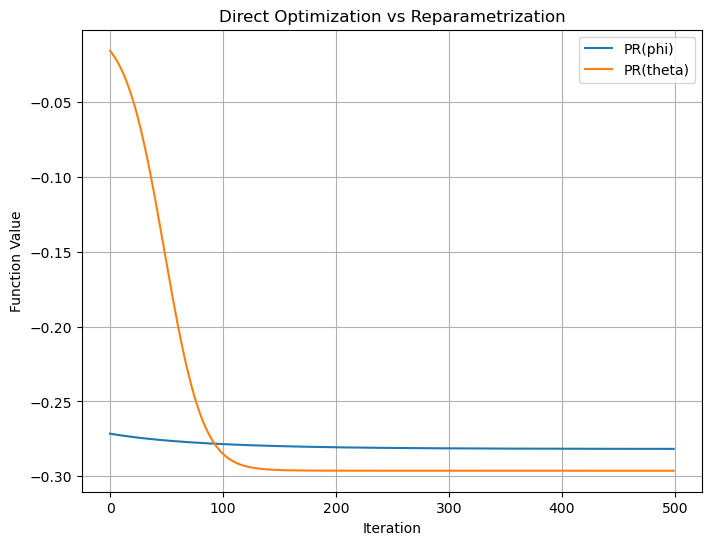

In [34]:
# Plotting the function value over iterations with the updated LearnModel
plt.figure(figsize=(8, 6))
plt.plot(g_values, label='PR(phi)')
plt.plot(f_values, label='PR(theta)')
#plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Function Value')
plt.title('Direct Optimization vs Reparametrization')
plt.grid(True)
plt.legend()
plt.show()


## multiple runs

In [208]:
# Define initial points
initial_points_x = np.linspace(0.25, 0.8, 10)  # 10 different initial points
#initial_points_x = np.linspace(0.3, 0.75, 10)  # 10 different initial points 
# # Generate initial points in y by squaring elements in x


In [209]:
print(initial_points_x)

[0.25       0.31111111 0.37222222 0.43333333 0.49444444 0.55555556
 0.61666667 0.67777778 0.73888889 0.8       ]


In [210]:
# Placeholder for iteration-wise results
g_iteration_values = []
f_iteration_values = []

# Number of iterations for each optimization process
num_iterations_g = 100
num_iterations_f = 100

# Initialize the results storage
for _ in range(num_iterations_g):
    g_iteration_values.append([])

for _ in range(num_iterations_f):
    f_iteration_values.append([])

# Perform optimizations for each initial point

for x0 in initial_points_x:
    x0_list = [x0]
    y0_list = [x0**2]
    
    # Modified optimization (phi space)
    _, g_values = modified_two_point_feedback_optimization(
        func = g,
        dim = 1,
        x0=x0_list,
        alpha=0.01,
        beta=0.1,
        num_iterations=num_iterations_g
    )
    for i, val in enumerate(g_values):
        g_iteration_values[i].append(val)
    
    # Default two-point feedback optimization (theta space)
    _, f_values = two_point_feedback_zeroth_order_optimization(
        func=f,
        dim=1,
        x0=y0_list,
        alpha=0.01,
        beta=0.1,
        num_iterations=num_iterations_f
    )
    for i, val in enumerate(f_values):
        f_iteration_values[i].append(val)

# Calculate averages and standard deviations for plotting
g_avg = [np.mean(vals) for vals in g_iteration_values]
g_std = [np.std(vals) for vals in g_iteration_values]
f_avg = [np.mean(vals) for vals in f_iteration_values]
f_std = [np.std(vals) for vals in f_iteration_values]


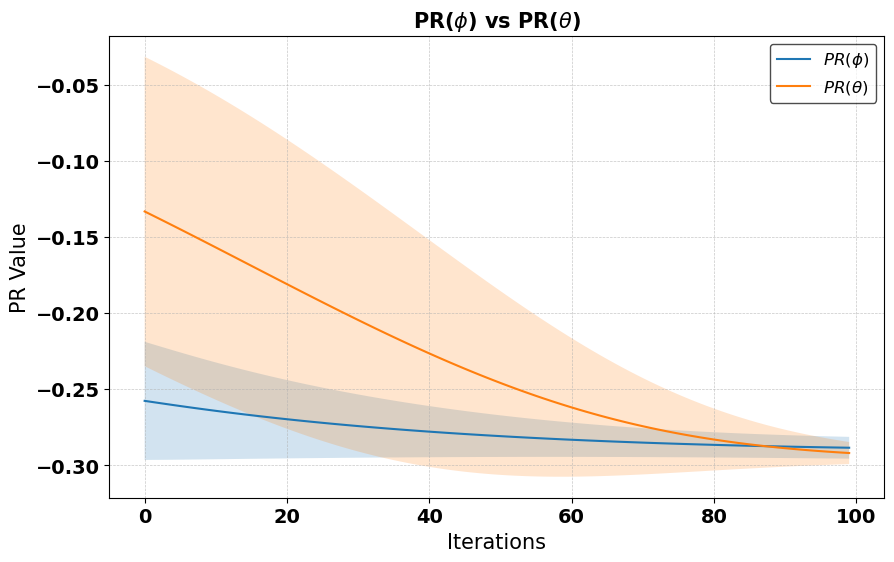

In [211]:
# Convert to NumPy arrays if not already (assuming these variables are defined as lists)
g_avg = np.array(g_avg)
g_std = np.array(g_std)
f_avg = np.array(f_avg)
f_std = np.array(f_std)

# Assuming num_iterations_g, num_iterations_f, g_avg, g_std, f_avg, f_std are defined

# Set the size of the plot
plt.figure(figsize=(10, 6), facecolor='white')

# Define the iteration range for g and f values
iterations_g = range(num_iterations_g)
iterations_f = range(num_iterations_f)

# Plotting for g_values and f_values across iterations with fill_between
plt.plot(iterations_g, g_avg, label=r'$PR(\phi)$')
plt.fill_between(iterations_g, g_avg - g_std, g_avg + g_std, alpha=0.2)

plt.plot(iterations_f, f_avg, label=r'$PR(\theta)$')
plt.fill_between(iterations_f, f_avg - f_std, f_avg + f_std, alpha=0.2)

# Customize the plot
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('PR Value', fontsize=15)
plt.title(r'PR($\phi$) vs PR($\theta$)', fontsize=15, fontweight='bold')

# Customizing the x-axis and y-axis tick labels
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Adding a grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding and customizing the legend
legend = plt.legend(frameon=True, fontsize=12)
legend.get_frame().set_alpha(0.7)
legend.get_frame().set_edgecolor("black")

# Save the plot if needed
plt.savefig('pr_comparison_test3.png')

# Show the plot
plt.show()